In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="Set2")

In [3]:
bps_frames = []

for year in [2020, 2021, 2022, 2023, 2024]:
    df = pd.read_excel(
        f"../data/raw/bps_health_{year}.xlsx",
        sheet_name="Sheet1",
        header=None
    )
    df = df.iloc[3:].copy()
    df.columns = ["province", "health_complaint_pct"]
    df = df[df["province"] != "INDONESIA"].copy()
    df["health_complaint_pct"] = pd.to_numeric(df["health_complaint_pct"], errors="coerce")
    df["year"] = year
    df["province"] = df["province"].str.strip().str.upper()
    bps_frames.append(df.reset_index(drop=True))

bps = pd.concat(bps_frames, ignore_index=True)

print("Shape      :", bps.shape)
print("Years      :", sorted(bps["year"].unique()))
print("Provinces  :", bps["province"].nunique())

Shape      : (190, 3)
Years      : [2020, 2021, 2022, 2023, 2024]
Provinces  : 38


In [4]:
print(bps.head(10).to_string())

               province  health_complaint_pct  year
0                  ACEH                 27.12  2020
1        SUMATERA UTARA                 26.12  2020
2        SUMATERA BARAT                 31.09  2020
3                  RIAU                 24.66  2020
4                 JAMBI                 21.63  2020
5      SUMATERA SELATAN                 29.32  2020
6              BENGKULU                 30.23  2020
7               LAMPUNG                 31.35  2020
8  KEP. BANGKA BELITUNG                 31.25  2020
9             KEP. RIAU                 18.21  2020


In [5]:
missing = bps.groupby("year")["health_complaint_pct"].apply(
    lambda x: x.isnull().sum()
).reset_index()
missing.columns = ["year", "missing_count"]
print(missing.to_string(index=False))

 year  missing_count
 2020              4
 2021              4
 2022              4
 2023              4
 2024              0


In [6]:
missing_prov = bps[bps["health_complaint_pct"].isnull()]["province"].unique()
print(missing_prov)

['PAPUA BARAT DAYA' 'PAPUA SELATAN' 'PAPUA TENGAH' 'PAPUA PEGUNUNGAN']


In [7]:
print(bps.groupby("year")["health_complaint_pct"].describe().round(2).to_string())

      count   mean   std    min    25%    50%    75%    max
year                                                       
2020   34.0  28.10  6.23  15.97  25.10  28.02  32.15  44.00
2021   34.0  24.96  5.80  12.74  21.51  25.76  28.43  42.15
2022   34.0  27.62  7.10  11.68  23.50  28.59  32.47  43.62
2023   34.0  25.27  5.24  12.64  22.78  25.16  27.75  39.40
2024   38.0  23.74  6.54   8.88  20.23  23.86  28.82  38.88


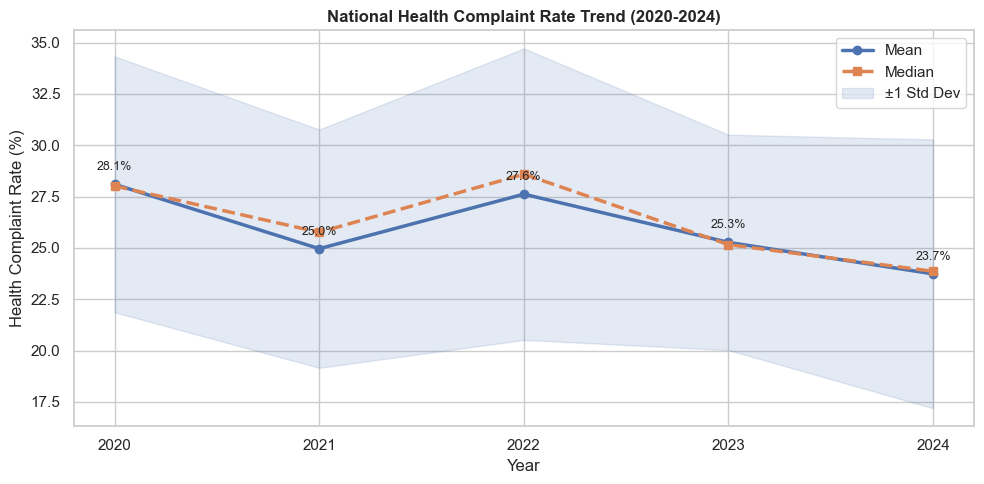

In [9]:
national_trend = bps.groupby("year")["health_complaint_pct"].agg(["mean", "median", "std"]).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(national_trend["year"], national_trend["mean"],
        marker="o", color="#4C72B0", linewidth=2.5, label="Mean")
ax.plot(national_trend["year"], national_trend["median"],
        marker="s", color="#DD8452", linewidth=2.5, linestyle="--", label="Median")
ax.fill_between(
    national_trend["year"],
    national_trend["mean"] - national_trend["std"],
    national_trend["mean"] + national_trend["std"],
    alpha=0.15, color="#4C72B0", label="±1 Std Dev"
)
ax.set_title("National Health Complaint Rate Trend (2020-2024)", fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Health Complaint Rate (%)")
ax.legend()
ax.set_xticks([2020, 2021, 2022, 2023, 2024])

for _, row in national_trend.iterrows():
    ax.annotate(f"{row['mean']:.1f}%",
                xy=(row["year"], row["mean"]),
                xytext=(0, 10), textcoords="offset points",
                ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("../data/processed/eda_health_01_national_trend.png", dpi=150, bbox_inches="tight")
plt.show()

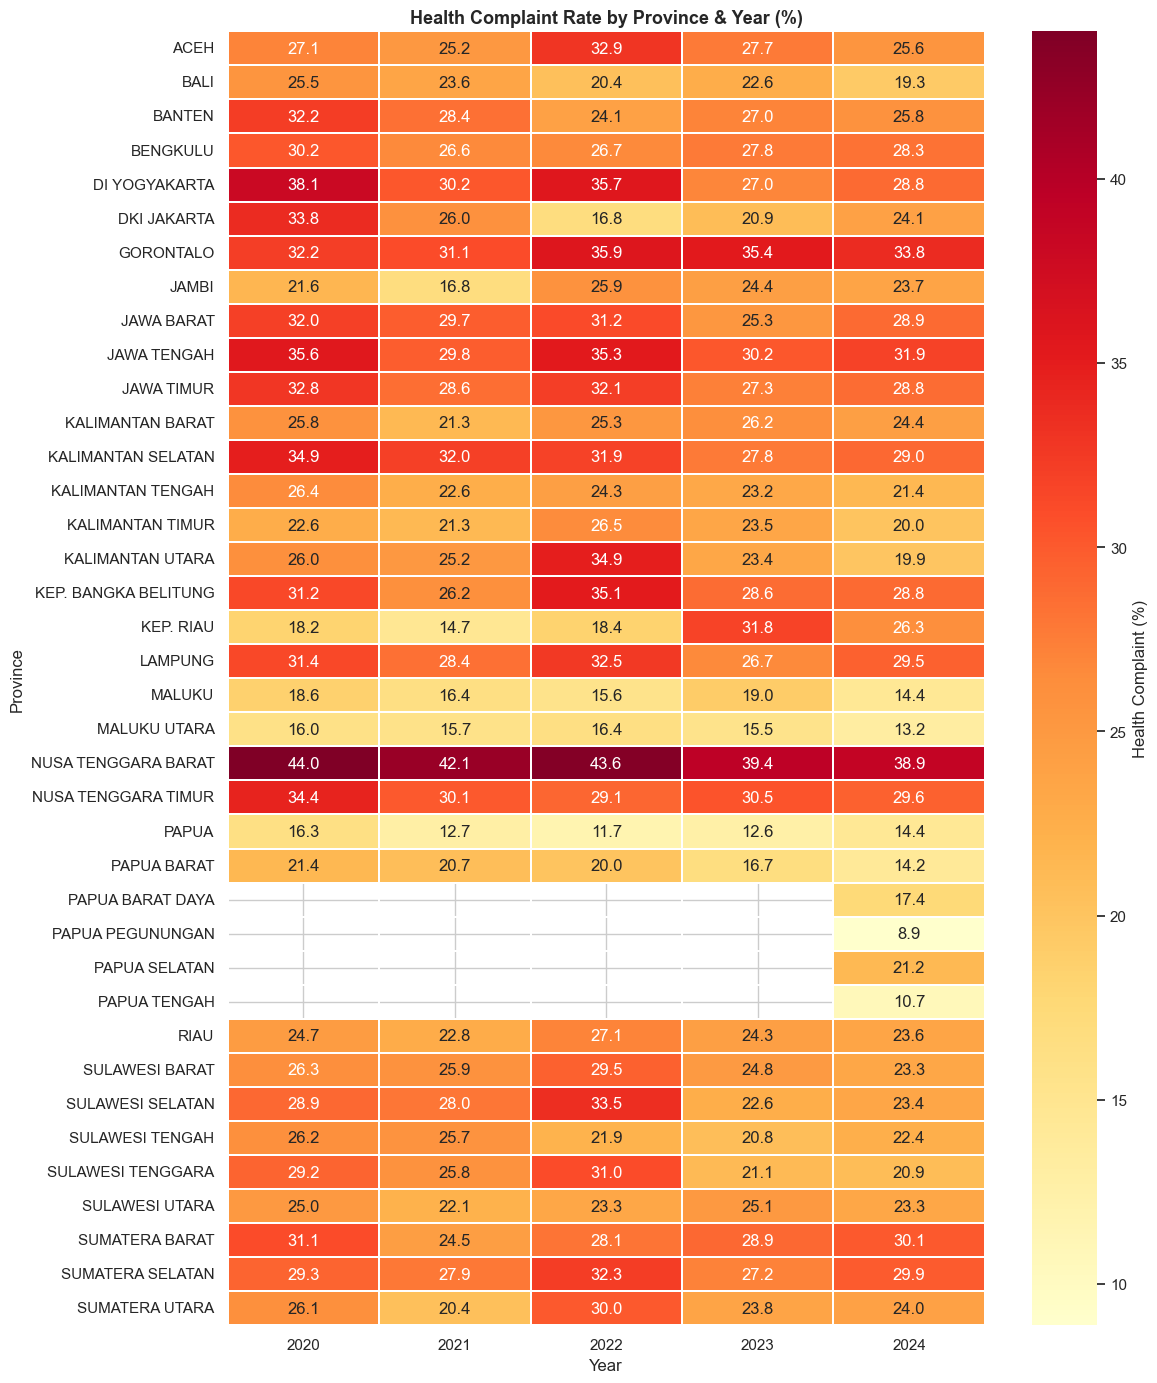

In [10]:
pivot = bps.pivot(index="province", columns="year", values="health_complaint_pct")

fig, ax = plt.subplots(figsize=(12, 14))
sns.heatmap(
    pivot, annot=True, fmt=".1f", cmap="YlOrRd",
    linewidths=0.3, ax=ax, cbar_kws={"label": "Health Complaint (%)"}
)
ax.set_title("Health Complaint Rate by Province & Year (%)", fontweight="bold", fontsize=13)
ax.set_xlabel("Year")
ax.set_ylabel("Province")

plt.tight_layout()
plt.savefig("../data/processed/eda_health_02_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

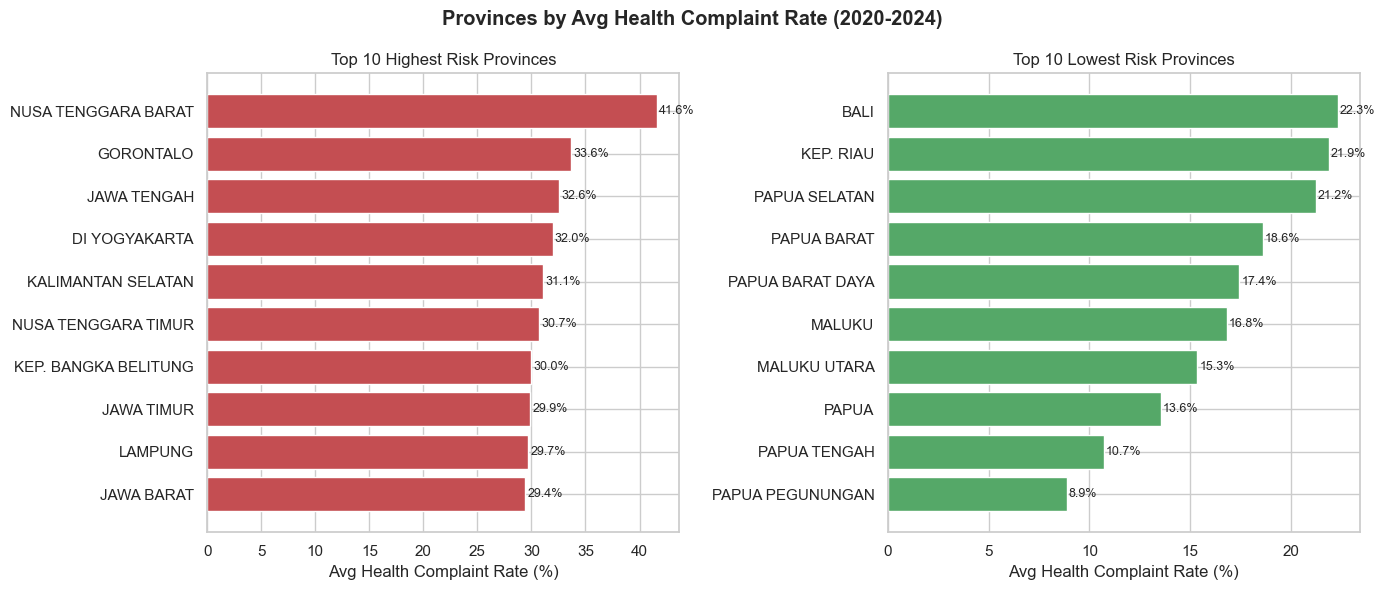

In [11]:
avg_by_province = bps.groupby("province")["health_complaint_pct"].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Provinces by Avg Health Complaint Rate (2020-2024)", fontweight="bold")

top10 = avg_by_province.head(10)
axes[0].barh(top10.index[::-1], top10.values[::-1], color="#C44E52")
axes[0].set_title("Top 10 Highest Risk Provinces")
axes[0].set_xlabel("Avg Health Complaint Rate (%)")
for i, v in enumerate(top10.values[::-1]):
    axes[0].text(v + 0.2, i, f"{v:.1f}%", va="center", fontsize=9)

bot10 = avg_by_province.tail(10)
axes[1].barh(bot10.index[::-1], bot10.values[::-1], color="#55A868")
axes[1].set_title("Top 10 Lowest Risk Provinces")
axes[1].set_xlabel("Avg Health Complaint Rate (%)")
for i, v in enumerate(bot10.values[::-1]):
    axes[1].text(v + 0.1, i, f"{v:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("../data/processed/eda_health_03_top_bottom.png", dpi=150, bbox_inches="tight")
plt.show()

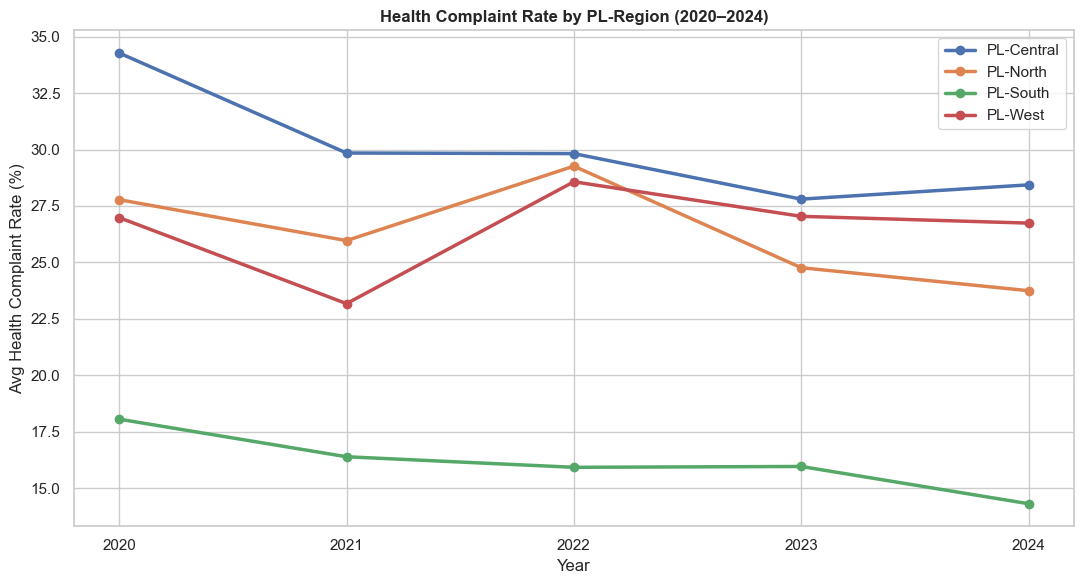

In [12]:
province_to_region = {
    "ACEH": "PL-West", "SUMATERA UTARA": "PL-West", "SUMATERA BARAT": "PL-West",
    "RIAU": "PL-West", "JAMBI": "PL-West", "SUMATERA SELATAN": "PL-West",
    "BENGKULU": "PL-West", "LAMPUNG": "PL-West", "KEP. BANGKA BELITUNG": "PL-West",
    "KEP. RIAU": "PL-West", "KALIMANTAN BARAT": "PL-West",
    "DKI JAKARTA": "PL-Central", "JAWA BARAT": "PL-Central", "JAWA TENGAH": "PL-Central",
    "DI YOGYAKARTA": "PL-Central", "JAWA TIMUR": "PL-Central", "BANTEN": "PL-Central",
    "BALI": "PL-Central", "NUSA TENGGARA BARAT": "PL-Central", "NUSA TENGGARA TIMUR": "PL-Central",
    "KALIMANTAN TENGAH": "PL-North", "KALIMANTAN SELATAN": "PL-North",
    "KALIMANTAN TIMUR": "PL-North", "KALIMANTAN UTARA": "PL-North",
    "SULAWESI UTARA": "PL-North", "SULAWESI TENGAH": "PL-North",
    "SULAWESI SELATAN": "PL-North", "SULAWESI TENGGARA": "PL-North",
    "GORONTALO": "PL-North", "SULAWESI BARAT": "PL-North",
    "MALUKU": "PL-South", "MALUKU UTARA": "PL-South", "PAPUA BARAT": "PL-South",
    "PAPUA BARAT DAYA": "PL-South", "PAPUA": "PL-South", "PAPUA SELATAN": "PL-South",
    "PAPUA TENGAH": "PL-South", "PAPUA PEGUNUNGAN": "PL-South",
}

bps["pl_region"] = bps["province"].map(province_to_region)
region_trend = bps.groupby(["year", "pl_region"])["health_complaint_pct"].mean().reset_index()

fig, ax = plt.subplots(figsize=(11, 6))
colors = {"PL-Central": "#4C72B0", "PL-North": "#DD8452",
          "PL-South": "#55A868", "PL-West": "#C44E52"}

for region, grp in region_trend.groupby("pl_region"):
    ax.plot(grp["year"], grp["health_complaint_pct"],
            marker="o", linewidth=2.5, label=region,
            color=colors.get(region, "grey"))

ax.set_title("Health Complaint Rate by PL-Region (2020–2024)", fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Avg Health Complaint Rate (%)")
ax.set_xticks([2020, 2021, 2022, 2023, 2024])
ax.legend()

plt.tight_layout()
plt.savefig("../data/processed/eda_health_04_region_trend.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
bps_sorted = bps.sort_values(["province", "year"])
bps_sorted["yoy_change"] = bps_sorted.groupby("province")["health_complaint_pct"].diff()

print("Provinces With Biggest YoY Increase (avg across all years):")
yoy = bps_sorted.groupby("province")["yoy_change"].mean().sort_values(ascending=False)
print(yoy.head(10).round(2).to_string())

print("\nProvinces With Biggest YoY Decrease:")
print(yoy.tail(10).round(2).to_string())

Provinces With Biggest YoY Increase (avg across all years):
province
KEP. RIAU           2.01
JAMBI               0.53
GORONTALO           0.40
SUMATERA SELATAN    0.14
SUMATERA BARAT     -0.25
RIAU               -0.26
KALIMANTAN BARAT   -0.37
ACEH               -0.39
SULAWESI UTARA     -0.42
LAMPUNG            -0.45

Provinces With Biggest YoY Decrease:
province
BALI                -1.54
BANTEN              -1.61
PAPUA BARAT         -1.81
SULAWESI TENGGARA   -2.09
DI YOGYAKARTA       -2.31
DKI JAKARTA         -2.43
PAPUA BARAT DAYA      NaN
PAPUA PEGUNUNGAN      NaN
PAPUA SELATAN         NaN
PAPUA TENGAH          NaN
